In [118]:
import torch, os, math, gzip, pickle
import matplotlib.pyplot as plt
from torchvision.io import read_image
from torch.utils.cpp_extension import load_inline

device = "cuda"

In [70]:
img = read_image("./puppy.jpg").to(device)
img.shape

torch.Size([3, 1330, 1920])

In [71]:
def show_img(x):
    plt.axis("off")
    has_colors = len(x.shape) == 3
    if has_colors:
        x = x.permute(1, 2, 0)
    x = x.cpu()
    if has_colors:
        plt.imshow(x)  # CHW -> HWC
    else:
        plt.imshow(x, cmap="gray")

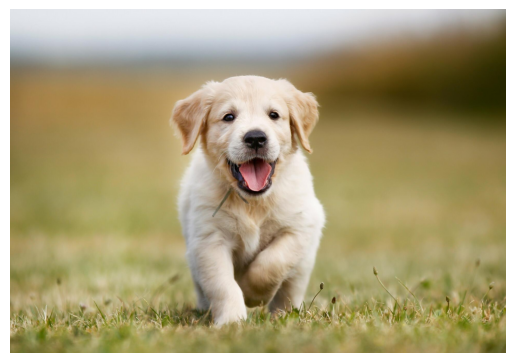

In [72]:
show_img(img)

In [73]:
def to_grayscale(img):
    ones = torch.tensor([0.2989, 0.5878, 0.1148], device=device)
    res = torch.einsum("c,cwh->wh", ones, img.float()).to(torch.uint8)
    return res

In [113]:
%%time
to_grayscale(img)

CPU times: user 1.23 ms, sys: 100 μs, total: 1.33 ms
Wall time: 1.21 ms


tensor([[228, 228, 228,  ..., 159, 158, 158],
        [228, 228, 228,  ..., 158, 158, 158],
        [228, 228, 228,  ..., 157, 157, 157],
        ...,
        [110, 111, 112,  ...,  86,  87,  87],
        [114, 114, 114,  ...,  87,  87,  88],
        [114, 114, 114,  ...,  87,  87,  88]], device='cuda:0',
       dtype=torch.uint8)

In [117]:
%load_ext wurlitzer

In [114]:
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

In [122]:
def load_cuda(cu_src, cpp_src, funcs: list[str]):
    return load_inline(
        cuda_sources=[cu_src],
        cpp_sources=[cpp_src],
        functions=funcs,
        extra_cuda_cflags=["--02"],
        name="custom_cuda",
    )

In [123]:
cuda_begin = r"""
#include <torch/extension.h>
#include <stdio.h>
#include <c10/cuda/CUDAException.h>

#define CHECK_CUDA(x) TORCH_CHECK(x.device().is_cuda(), #x " must be a CUDA tensor")
#define CHECK_CONTIGUOUS(x) TORCH_CHECK(x.is_contiguous(x), #x " must be contiguous")
#define CHECK_INPUT(x) CHECK_CUDA(x); CHECK_CONTIGUOUS(x)

inline unsinged ceil_div(unsigned int x, unsigned int y) { return (x + y - 1) / y; }
"""